#Assignment 7
##Designing of ENAS on CIFAR10

####Intialising the Liabraries

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


####Importing the CIFAR10 from Keras

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


####Assigning Class Names

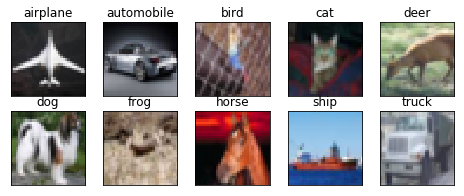

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

####Defining the function to store Loss and Accuracy Values

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

####Defining the function to Calculate Accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

####Normalising the Values between 0-1 and converting to float

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

####Network Architecture and Summary

In [9]:
# import Libraries
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.layers import Input, Convolution2D, BatchNormalization, Dropout, SeparableConv2D, concatenate, MaxPooling2D, Flatten, Activation, Lambda
from keras.models import Model

import tensorflow as tf


def spacetodepth(x, block_size=2):
    return tf.space_to_depth(x, block_size= block_size)



input = Input(shape=(32, 32, 3))



############################## Block-I ####################################
layer11 = SeparableConv2D(8, 5, 5, activation='relu', border_mode='same')(input) 
layer11 = BatchNormalization()(layer11)
layer11 = Dropout(0.2)(layer11)


L11 = Lambda(spacetodepth)(layer11)
L12 = Lambda(spacetodepth)(L11)


layer12 = Convolution2D(16, 5, 5, activation='relu', border_mode='same') (layer11) 
layer12 = BatchNormalization()(layer12)
layer12 = Dropout(0.25)(layer12)


L13 = Lambda(spacetodepth)(layer12)
L14 = Lambda(spacetodepth)(L13)



layer13 = Convolution2D(32, 5, 5, activation='relu', border_mode='same') (layer12) 
layer13 = BatchNormalization()(layer13)
layer13 = Dropout(0.25)(layer13)


L15 = Lambda(spacetodepth)(layer13)
L16 = Lambda(spacetodepth)(L15)



############################## Concat-I ####################################
concat1 = concatenate([layer11, layer13]) 

layer14 = SeparableConv2D(64, 5, 5, activation='relu', border_mode='same')(concat1) 
layer14 = BatchNormalization()(layer14)
layer14 = Dropout(0.25)(layer14)


L17 = Lambda(spacetodepth)(layer14)
L18 = Lambda(spacetodepth)(L17)



############################## Concat-II ####################################
concat2 = concatenate([layer11, layer14]) 

M1 = MaxPooling2D(pool_size=(2, 2)) (concat2) 




############################## Block-II ####################################
layer21 = SeparableConv2D(8, 3, 3, activation='relu', border_mode='same')(M1) 
layer21 = BatchNormalization()(layer21)
layer21 = Dropout(0.25)(layer21)

L19 = Lambda(spacetodepth)(layer21)

############################## Concat-III ####################################

concat31 = concatenate([L11, layer21]) 
concat32 = concatenate([L17, layer21]) 
B_concat1 = concatenate([concat31, concat32])

layer22 = Convolution2D(16, 5, 5, activation='relu', border_mode='same') (B_concat1) 
layer22 = BatchNormalization()(layer22)
layer22 = Dropout(0.25)(layer22)


concat33 = concatenate([layer21, layer22])
concat34 = concatenate([L15, layer22])
concat35 = concatenate([L17, layer22])
B_concat2 = concatenate([concat33, concat34, concat35])

layer23 = SeparableConv2D(32, 3, 3, activation='relu', border_mode='same')(B_concat2) 
layer23 = BatchNormalization()(layer23)
layer23 = Dropout(0.25)(layer23)

concat36 = concatenate([layer21, layer23])
concat37 = concatenate([L15, layer23])
concat38 = concatenate([L11, concat37]) 
B_concat3 = concatenate([concat36, concat37, concat38])


layer24 = SeparableConv2D(64, 5, 5, activation='relu', border_mode='same')(B_concat3) 
layer24 = BatchNormalization()(layer24)
layer24 = Dropout(0.25)(layer24)

concat39 = concatenate([L11, layer24])
concat40 = concatenate([L17, layer24])
B_concat4 = concatenate([concat39, concat40])
M2 = MaxPooling2D(pool_size=(2, 2)) (B_concat4) 


############################## Block-III ####################################
layer31 = Convolution2D(8, 5, 5,  border_mode='same') (M2) 
layer31 = BatchNormalization()(layer31)
layer31 = Dropout(0.25)(layer31)



concat41 = concatenate([L12, layer31]) 
concat42 = concatenate([L14, layer31]) 
concat43 = concatenate([L16, layer31]) 
concat44 = concatenate([L18, layer31]) 
B_concat5 = concatenate([concat41, concat42, concat43, concat44]) 


layer32 = SeparableConv2D(16, 5, 5, border_mode='same')(B_concat5)
layer32 = BatchNormalization()(layer32)
layer32 = Dropout(0.25)(layer32)


concat45 = concatenate([L14, layer32])

layer33 = Convolution2D(32, 3, 3, border_mode='same') (concat45) 
layer33= BatchNormalization()(layer33)
layer33 = Dropout(0.25)(layer33)


concat46 = concatenate([L19, layer33])
concat47 = concatenate([L12, layer33]) 
concat48 = concatenate([L18,layer33])
B_concat6 = concatenate([concat46, concat47, concat48])

layer34 = SeparableConv2D(64, 5, 5, border_mode='same')(B_concat6) 


concat49 = concatenate([L18,layer34])

flayer = Convolution2D(10, 8, 8) (concat49)




output = Flatten()(flayer)
output= Activation('softmax')(output)
model = Model(inputs=[input], outputs=[output])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(8, (5, 5), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, (5, 5), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(8, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_13 (SeparableC (None, 32, 32, 8)    107         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 8)    32          separable_conv2d_13[0][0]        
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 32, 32, 8)    0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
conv2d_10 

###Train the Model and find an accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=195, epochs=100)`
  
W0711 01:00:24.915452 140061765199744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruct

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


195/195 [==============================] - 88s 451ms/step - loss: 3.2233 - acc: 0.3587 - val_loss: 4.3954 - val_acc: 0.2167
Epoch 2/100
195/195 [==============================] - 80s 410ms/step - loss: 1.6668 - acc: 0.4881 - val_loss: 3.6943 - val_acc: 0.2091
Epoch 3/100
195/195 [==============================] - 79s 407ms/step - loss: 1.1704 - acc: 0.5872 - val_loss: 1.1821 - val_acc: 0.5893
Epoch 4/100
195/195 [==============================] - 79s 407ms/step - loss: 1.0382 - acc: 0.6350 - val_loss: 1.0941 - val_acc: 0.6195
Epoch 5/100
195/195 [==============================] - 79s 407ms/step - loss: 0.9455 - acc: 0.6657 - val_loss: 1.0768 - val_acc: 0.6260
Epoch 6/100
195/195 [==============================] - 79s 406ms/step - loss: 0.8648 - acc: 0.6934 - val_loss: 1.0996 - val_acc: 0.6283
Epoch 7/100
195/195 [==============================] - 79s 407ms/step - loss: 0.7981 - acc: 0.7182 - val_loss: 1.0981 - val_acc: 0.6391
Epoch 8/100
195/195 [==============================] - 79s 4

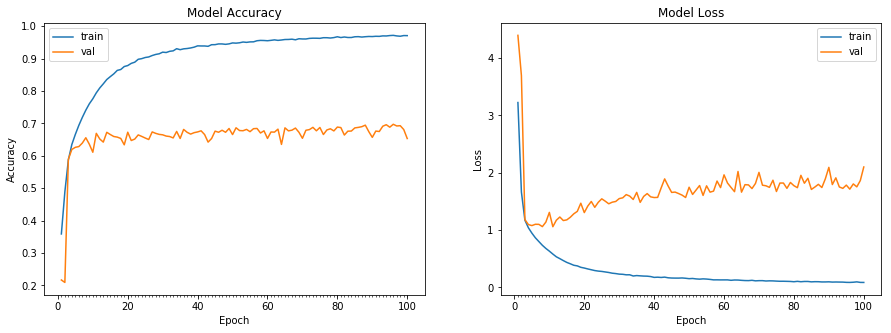

Accuracy on test data is: 65.31


In [10]:
from keras.preprocessing.image import ImageDataGenerator
import time

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, featurewise_center=True, featurewise_std_normalization=True)


# train the model
start = time.time()

# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

####Designed the complete network by excluding few skip connections